# Image Compression using PCA and K-Means

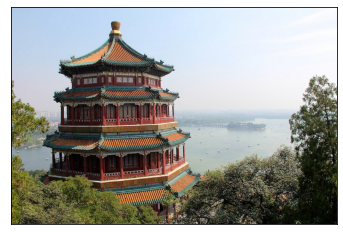

In [12]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [51]:
china.shape
data1 = china / 255.0 # use 0...1 scale
data1 = data1.reshape(427 * 640, 3)
data1.shape

(273280, 3)

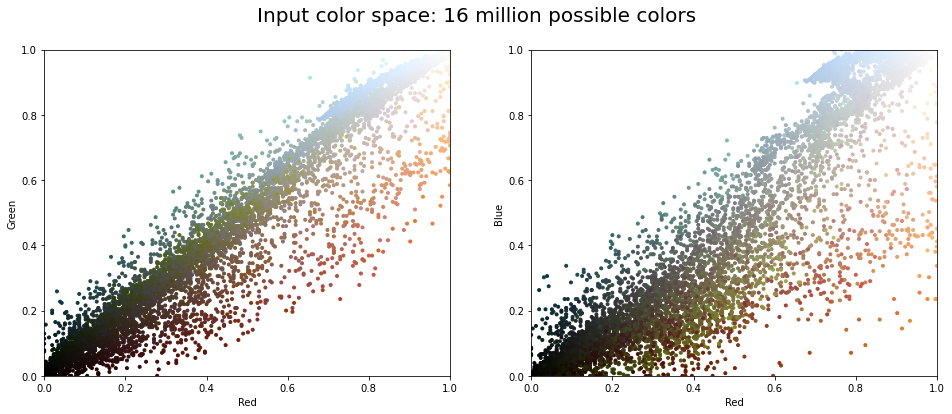

In [52]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data1
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data1.shape[0])[:N]
    colors = colors[i]
    R, G, B = data1[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);
    
plot_pixels(data, title='Input color space: 16 million possible colors')


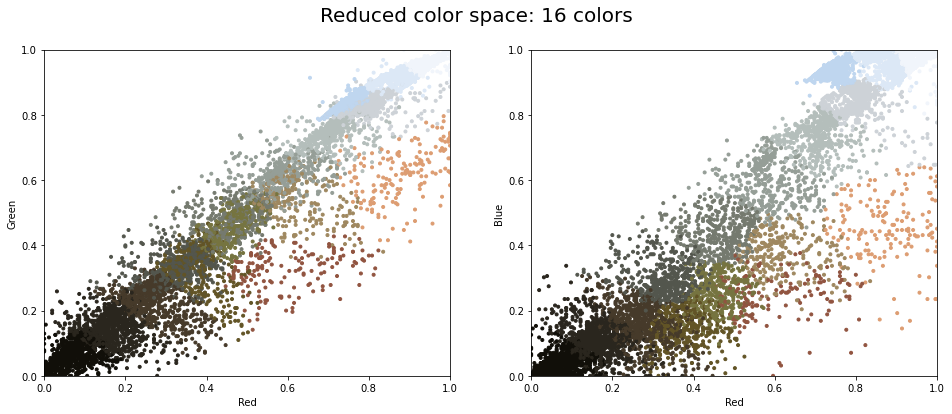

In [55]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data1)
new_colors = kmeans.cluster_centers_[kmeans.predict(data1)]

plot_pixels(data1, colors=new_colors,
            title="Reduced color space: 16 colors")

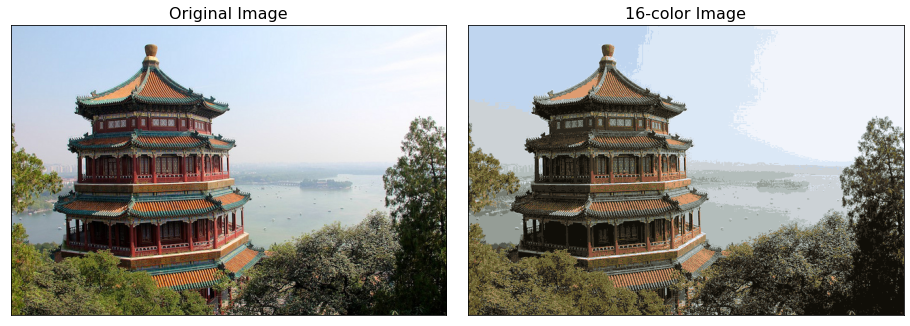

In [56]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

## Same Method, Different Image Example

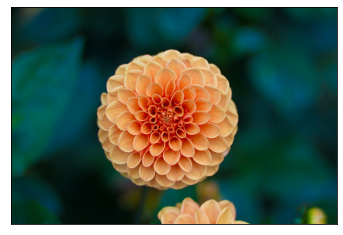

In [57]:
flower = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower);

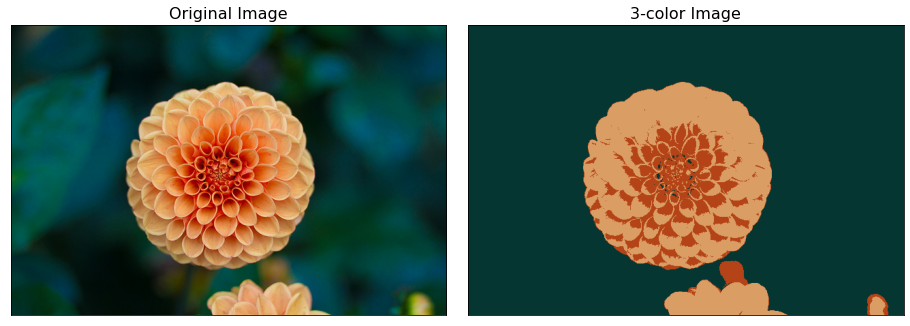

In [63]:
flower_recolored = new_colors.reshape(flower.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(flower_recolored)
ax[1].set_title('3-color Image', size=16);

## Data Compression using kPCA

In [1]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def stepwise_kpca(X, gamma, n_components):
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    K = np.exp(-gamma * mat_sq_dists)
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    eigvals, eigvecs = eigh(K)
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))
    return X_pc

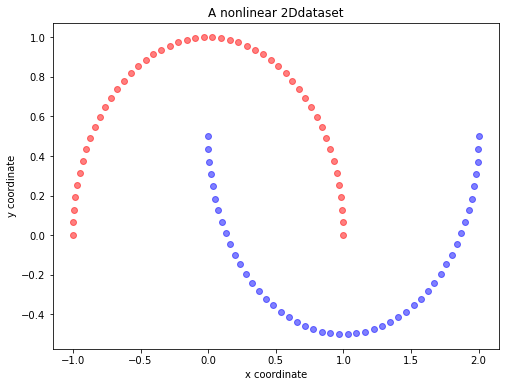

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

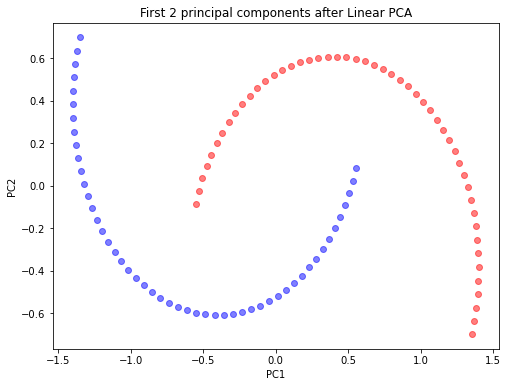

In [3]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

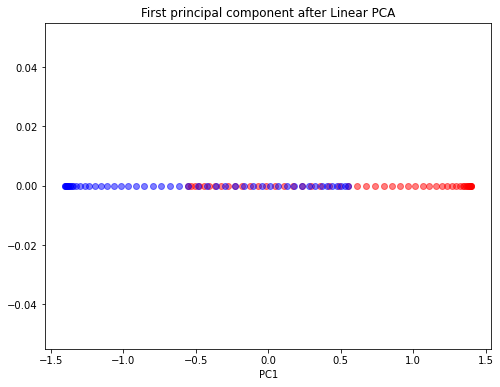

In [4]:
import numpy as np
scikit_pca = PCA(n_components=1)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], np.zeros((50,1)), color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], np.zeros((50,1)), color='blue', alpha=0.5)

plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')

plt.show()

/tmp/ipykernel_881/4107322604.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))


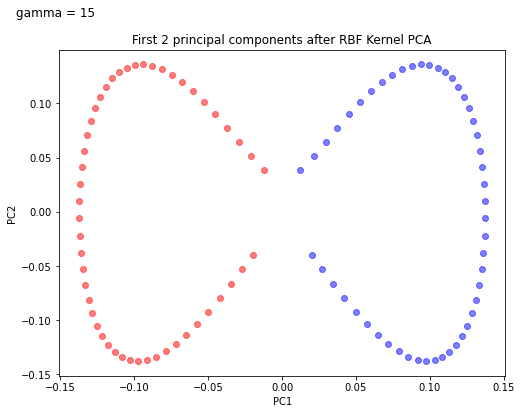

In [5]:
X_pc = stepwise_kpca(X, gamma=15, n_components=2)

plt.figure(figsize=(8,6))
plt.scatter(X_pc[y==0, 0], X_pc[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_pc[y==1, 0], X_pc[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after RBF Kernel PCA')
plt.text(-0.18, 0.18, 'gamma = 15', fontsize=12)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

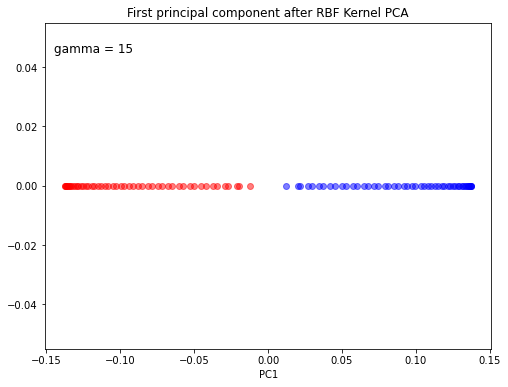

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(X_pc[y==0, 0], np.zeros((50)), color='red', alpha=0.5)
plt.scatter(X_pc[y==1, 0], np.zeros((50)), color='blue', alpha=0.5)

plt.title('First principal component after RBF Kernel PCA')
plt.text(-0.145, 0.045, 'gamma = 15', fontsize=12)
plt.xlabel('PC1')
plt.show()

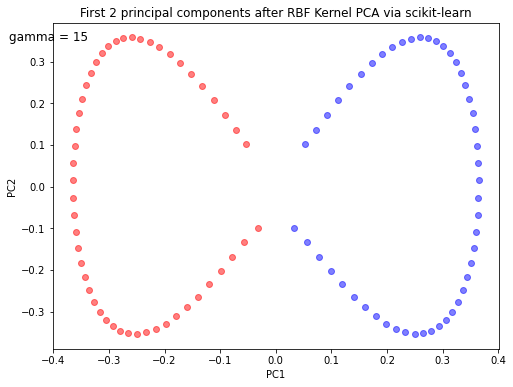

In [7]:
from sklearn.decomposition import KernelPCA

scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], color='blue', alpha=0.5)

plt.text(-0.48, 0.35, 'gamma = 15', fontsize=12)
plt.title('First 2 principal components after RBF Kernel PCA via scikit-learn')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

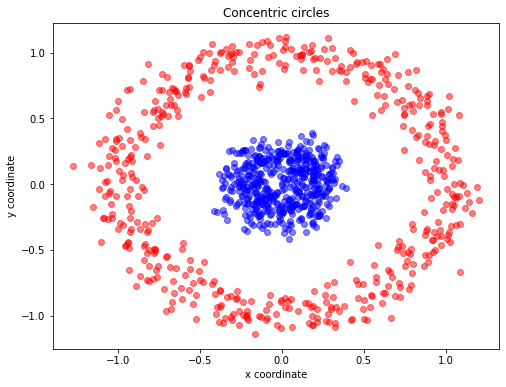

In [9]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('Concentric circles')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

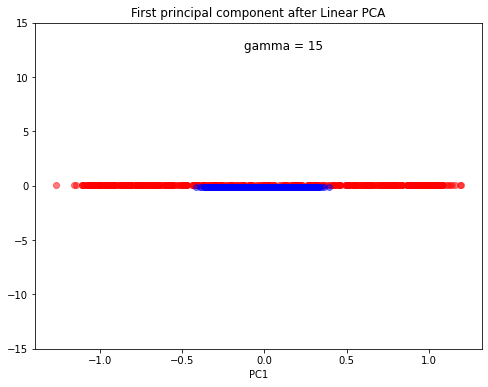

In [10]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], np.zeros((500,1))+0.1, color='red', alpha=0.5)
plt.scatter(X[y==1, 0], np.zeros((500,1))-0.1, color='blue', alpha=0.5)
plt.ylim([-15,15])
plt.text(-0.125, 12.5, 'gamma = 15', fontsize=12)
plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')
plt.show()

/tmp/ipykernel_881/4107322604.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))


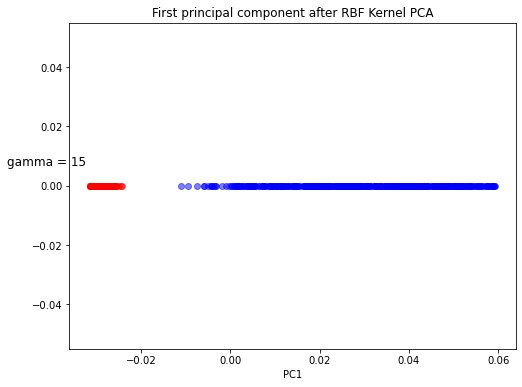

In [11]:
X_pc = stepwise_kpca(X, gamma=15, n_components=1)

plt.figure(figsize=(8,6))
plt.scatter(X_pc[y==0, 0], np.zeros((500,1)), color='red', alpha=0.5)
plt.scatter(X_pc[y==1, 0], np.zeros((500,1)), color='blue', alpha=0.5)
plt.text(-0.05, 0.007, 'gamma = 15', fontsize=12)
plt.title('First principal component after RBF Kernel PCA')
plt.xlabel('PC1')
plt.show()

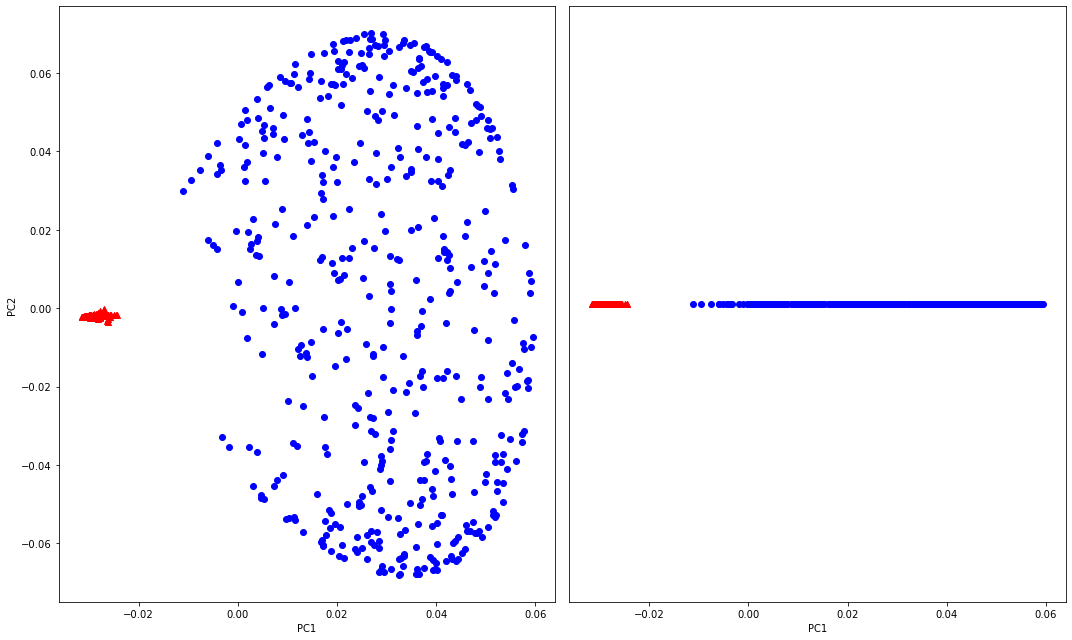

In [73]:
X_kpca = stepwise_kpca(X, gamma = 15, n_components=2)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,9))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color = 'red', marker = '^', alpha = 1)
ax[0].scatter(X_kpca[y ==1,0], X_kpca[y == 1,1], color = 'blue', marker = 'o', alpha = 1)
ax[1].scatter(X_kpca[y ==0,0], np.zeros((500,1)), color = 'red', marker = '^', alpha = 1)
ax[1].scatter(X_kpca[y ==1,0], np.zeros((500,1)), color = 'blue', marker = 'o', alpha = 1)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()